In [3]:
import torch 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from cdft.dft1d import dft_core
from cdft.lj_eos import lj_eos

device = torch.device('cpu')

pi = np.pi
kB = 1.380649e-23
NA = 6.02214076e23

plt.rcParams.update({'text.usetex':True, 
'font.family':'serif', 
'font.size':18, 
})

In [4]:
sigma = 3.575
epsilon = 94.45
parameters = {'sigma':sigma, 'epsilon':epsilon}

In [5]:
T = 77.4
eos = lj_eos(parameters, T)
P0 = 1.0186e5
P = torch.hstack((torch.arange(1e-7,1e-6,0.5e-7,dtype=torch.float64),torch.arange(1e-6,1e-5,0.5e-6,dtype=torch.float64),
                 torch.arange(1e-5,1e-4,0.5e-5,dtype=torch.float64),torch.arange(1e-4,1e-3,0.5e-4,dtype=torch.float64),
                 torch.arange(1e-3,1e-2,0.5e-3,dtype=torch.float64), torch.arange(1e-2,1e-1,0.5e-2,dtype=torch.float64),
                 torch.arange(0.1,0.7,0.01,dtype=torch.float64), torch.arange(0.7,0.85,0.005,dtype=torch.float64),
                 torch.arange(0.85,0.9,0.003,dtype=torch.float64), torch.arange(0.9,0.93,0.002,dtype=torch.float64),
                 torch.arange(0.93,1.0,0.0015,dtype=torch.float64)))*P0

bulk_density = torch.empty_like(P)

bulk_density[0] = eos.density(P[0],'vap')
for i in range(1,len(P)):
    bulk_density[i] = eos.density(P[i],bulk_density[i-1])

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_17393/1789170785.py:1: SyntaxWarning: invalid escape sequence '\s'
  nist = pd.read_csv('data/N2_77K_NIST.txt', sep='\s+', skiprows=1,


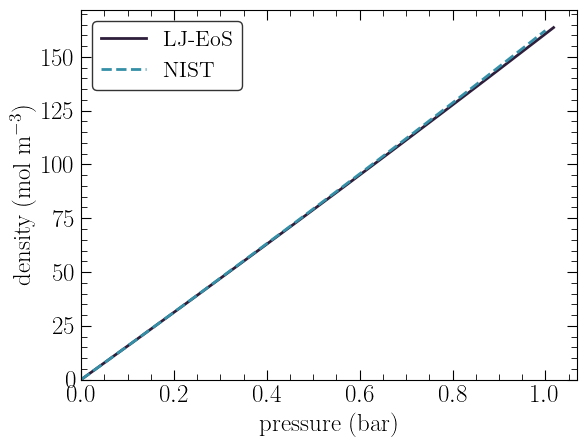

In [6]:
nist = pd.read_csv('data/N2_77K_NIST.txt', sep='\s+', skiprows=1, 
                    usecols=[1,2], names=['Pressure (bar)','Density (mol/m3)'])

colors = sns.color_palette("mako")

plt.plot(P*1e-5, bulk_density*1e30/(NA), '-', color=colors[0], linewidth=2.0, label='LJ-EoS')
plt.plot(nist['Pressure (bar)'],nist['Density (mol/m3)'], '--', color=colors[3], linewidth=2.0, label='NIST')
plt.xlabel(r'pressure (bar)', fontsize=18)
plt.ylabel(r'density (mol m$^{-3}$)', fontsize=18)
plt.xlim([0.0,None])
plt.ylim([0.0,None])
plt.minorticks_on()
plt.tick_params(direction='in',right=True, top=True)
plt.tick_params(labelsize=18)
plt.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
# xticks = np.arange(0, 1e4,10)
# yticks = np.arange(0,16.1,4)
plt.tick_params(direction='in',which='minor', length=4, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=7, bottom=True, top=True, left=True, right=True)
# plt.xticks(xticks)
# plt.yticks(yticks)
plt.legend(fontsize=16, frameon=True, edgecolor='k')

In [7]:
H = 20.0
system_size = H+10
points = int(system_size*100)

def steele(z,sigma,epsilon):
    rhos = 0.114
    Delta = 3.35
    return 2.0*pi*rhos*epsilon*sigma**2*Delta*(0.40*(sigma/z)**10-(sigma/z)**4-sigma**4/(3.0*Delta*(z+0.610*Delta)**3))

sigma_s = 3.40
epsilon_s = 28.0
sigma_is = 0.5*(sigma+sigma_s) 
epsilon_is = np.sqrt(epsilon*epsilon_s)

dft = dft_core(parameters, T, system_size, points, device)
Vext = torch.zeros(dft.points, dtype=torch.float64)
kin = 500
kout = int(system_size*100-kin)
Vext[0:kin] = np.inf
Vext[kout:] = np.inf
Vext[kin:kout] = steele(dft.z[kin:kout]-5, sigma_is, epsilon_is)+steele(H-(dft.z[kin:kout]-5), sigma_is, epsilon_is)

In [8]:
dft.initial_condition(bulk_density[0],Vext)
Nads = torch.empty_like(P)
Ndes = torch.empty_like(P) 
Omega_ads = torch.empty_like(P)
Omega_des = torch.empty_like(P)

for i in range(len(P)):
    dft.equilibrium_density_profile(bulk_density[i],fmt='ASWB',solver='fire',
                                    alpha0=0.2,dt=0.01,tol=1e-6,logoutput=False)
    Nads[i] = dft.total_molecules 
    Omega_ads[i] = dft.Omega
    print(dft.it,dft.error.numpy(),P[i].numpy()/P0,Nads[i].numpy())   
    if np.isnan(dft.error.numpy()): break

128 3.324171895913926e-08 1e-07 5.267250952372404e-06
124 7.770993311593494e-07 1.5e-07 7.901522736513075e-06
122 9.563306261418536e-07 2e-07 1.0536233791125821e-05
121 9.146785870372233e-07 2.5e-07 1.317138440568755e-05
119 9.68640280927298e-07 3e-07 1.5806969973504753e-05
117 9.849775723811678e-07 3.4999999999999993e-07 1.844299313398944e-05
115 9.818621276886226e-07 4e-07 2.1079453914699104e-05
112 9.910807442951433e-07 4.5e-07 2.3716351579339428e-05
108 9.935462664786122e-07 5e-07 2.6353686874728746e-05
103 9.969553877713984e-07 5.5e-07 2.8991459697844702e-05
97 9.953341686707987e-07 6e-07 3.162967046626998e-05
89 9.822923069420475e-07 6.499999999999999e-07 3.426831972268015e-05
89 9.500127699862597e-07 6.999999999999999e-07 3.6907408166441304e-05
89 9.225532114519173e-07 7.5e-07 3.954693476355331e-05
89 8.989788312052248e-07 8e-07 4.218689966304477e-05
89 8.785816901801781e-07 8.499999999999999e-07 4.482730301358711e-05
89 8.60816001341917e-07 9e-07 4.746814496358476e-05
89 8.4525

In [9]:
Ndes[-1] = dft.total_molecules
Omega_des[-1] = dft.Omega
for i in range(len(P)-2,-1,-1):
    dft.equilibrium_density_profile(bulk_density[i],fmt='ASWB',solver='fire',
                                    alpha0=0.2,dt=0.01,tol=1e-6,logoutput=False)
    Ndes[i] = dft.total_molecules 
    Omega_des[i] = dft.Omega
    print(dft.it,dft.error.numpy(),P[i].numpy()/P0,Ndes[i].numpy())   
    if np.isnan(dft.error.numpy()): break

116 9.806538836507431e-07 0.9975 0.3415816726840257
116 9.855423138212435e-07 0.996 0.34157025541945146
116 9.857752618455124e-07 0.9945 0.3415588180529311
116 9.858506605870416e-07 0.9930000000000001 0.3415473605916051
116 9.859220481356573e-07 0.9915 0.34153588297137405
116 9.85994407619721e-07 0.9900000000000001 0.3415243851259379
116 9.860673508366383e-07 0.9885 0.3415128669886632
116 9.861407093666072e-07 0.9870000000000001 0.34150132849260245
116 9.862142134118763e-07 0.9855 0.3414897695704683
116 9.862876146747703e-07 0.9840000000000001 0.3414781901546543
116 9.863608009535786e-07 0.9824999999999999 0.34146659017722625
116 9.864335714032166e-07 0.981 0.3414549695699063
116 9.86505825512474e-07 0.9795000000000001 0.3414433282640896
116 9.86577454608709e-07 0.9780000000000002 0.3414316661908325
116 9.866483986376572e-07 0.9765 0.34141998328084955
116 9.867185886268252e-07 0.9750000000000001 0.3414082794645167
116 9.86788022518095e-07 0.9735 0.3413965546718689
116 9.868566741492944

In [13]:
Neq = np.copy(Nads)
Omega_eq = np.copy(Omega_ads)
for i in range(len(P)):
    if Omega_des[i] < Omega_ads[i]:
        Omega_eq[i] = Omega_des[i]
        Neq[i] = Ndes[i]

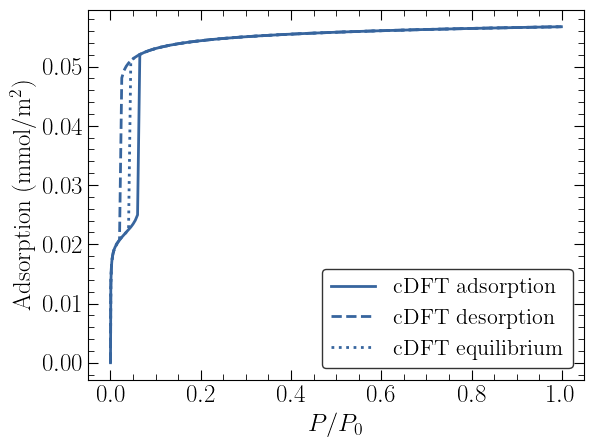

In [14]:
colors = sns.color_palette("mako")

plt.plot(P/P0, (1e23/NA)*Nads, '-', color=colors[2], linewidth=2.0, label='cDFT adsorption')
plt.plot(P/P0, (1e23/NA)*Ndes, '--', color=colors[2], linewidth=2.0, label='cDFT desorption')
plt.plot(P/P0, (1e23/NA)*Neq, ':', color=colors[2], linewidth=2.0, label='cDFT equilibrium')
plt.xlabel(r'$P/P_0$', fontsize=18)
plt.ylabel(r'Adsorption (mmol/m$^2$)', fontsize=18)
# plt.xlim([0.0,0.4])
# plt.ylim([0.0,2000])
plt.minorticks_on()
plt.tick_params(direction='in',right=True, top=True)
plt.tick_params(labelsize=18)
plt.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
plt.tick_params(direction='in',which='minor', length=4, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=7, bottom=True, top=True, left=True, right=True)
plt.legend(fontsize=16, frameon=True, edgecolor='k')

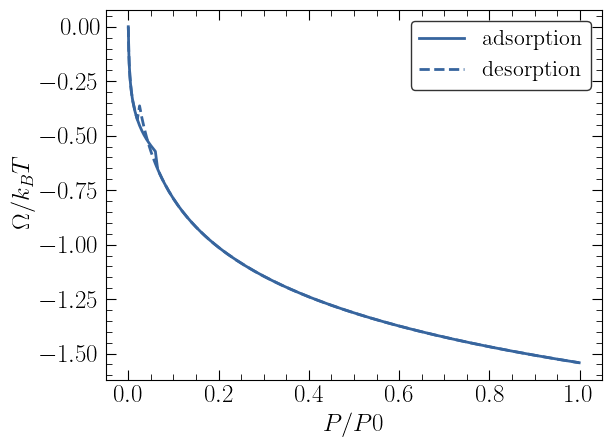

In [18]:
colors = sns.color_palette("mako")

plt.plot(P/P0, Omega_ads, '-', color=colors[2], linewidth=2.0, label='adsorption')
plt.plot(P/P0, Omega_des, '--', color=colors[2], linewidth=2.0, label='desorption')
plt.xlabel(r'$P/P0$', fontsize=18)
plt.ylabel(r'$\Omega/k_B T$', fontsize=18)
# plt.xlim([0.0,5.0])
# plt.ylim([0.0,2000])
plt.minorticks_on()
plt.tick_params(direction='in',right=True, top=True)
plt.tick_params(labelsize=18)
plt.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
plt.tick_params(direction='in',which='minor', length=4, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=7, bottom=True, top=True, left=True, right=True)
plt.legend(fontsize=16, frameon=True, edgecolor='k')